In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
from scipy.stats import gmean

### Security Market Line

In [2]:
# constants
TICKERS = [
    'MSFT', 'TSLA', 'NVDA', 'GME', 'BB', 'CAT', 'T', 'JPM', 'COST', 'WMT', 
    'NKE', 'GM', 'F', 'MMM', 'EA', 'CMG', 'HD', 'BA', 'LMT', 'AXP',
    'AMZN', 'AMD', 'AAPL', 'GOOGL', 'LLY', 'BAC', 'MCD', 'KO', 'PEP', 'YUM'
]
start = '2014-01-01'
end = '2023-12-31'
mu_f = 0.042

In [3]:
# Get the data
market = yf.download('^GSPC', start=start, end=end).dropna()
assets = yf.download(TICKERS, start=start, end=end).dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  30 of 30 completed


In [4]:
# expected return based on historical average
def calculate_expected_return(data: pd.Series) -> float:
    daily_returns = gmean(data.pct_change().dropna() + 1) - 1
    return (daily_returns + 1) ** 252 - 1

In [5]:
# calculate beta based on covariance
def calculate_beta(stock_returns: pd.Series, market_returns: pd.Series, annual_market_variance: float) -> float:
    if market_returns.shape[0] != stock_returns.shape[0]:
        raise ValueError(f'Length of {ticker} and market returns do not match!')
    
    cov = np.cov(stock_returns, market_returns)[0][1]*252
    
    return cov / annual_market_variance

In [6]:
mu_m = calculate_expected_return(market['Adj Close'])
mu_i = calculate_expected_return(assets['Adj Close'])

# generate SML
beta = np.linspace(0, 2, 1000)
sml = mu_f + beta * (mu_m - mu_f)

# beta of stocks
daily_returns_market = market['Adj Close'].pct_change().dropna()
annual_var_market = np.var(daily_returns_market)*252

data = {}
for index, ticker in enumerate(assets['Adj Close'].columns):
    try:
        data.setdefault(ticker, {})
                
        stock_returns = assets['Adj Close'][ticker].pct_change().dropna()
        data[ticker]['beta_i'] = calculate_beta(
            stock_returns,
            daily_returns_market,
            annual_var_market
        )
        data[ticker]['mu_i'] = mu_i[index]
    except Exception as e:
        print(e)
        continue

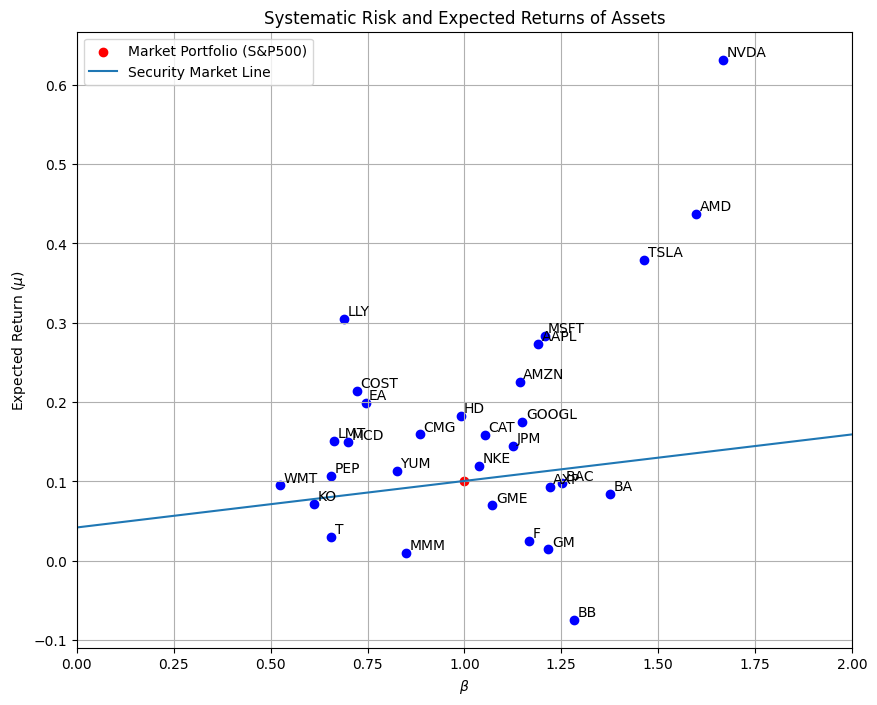

In [7]:
# plotting beta vs expected returns
plt.figure(figsize=(10, 8))
plt.scatter(1, mu_m, color='red', label='Market Portfolio (S&P500)') # Market Portfolio
plt.plot(beta, sml, label='Security Market Line') # SML

for ticker, value in data.items():
    plt.scatter(value['beta_i'], value['mu_i'], color='b')
    plt.annotate(
        ticker, 
        xy=(value['beta_i'], value['mu_i']),
        xycoords='data',
        xytext=(2.5, 2.5),
        textcoords='offset points',
    )

plt.ylabel(rf'Expected Return ($\mu$)')
plt.xlabel(rf'$\beta$')
plt.title('Systematic Risk and Expected Returns of Assets')
plt.xlim(xmin=0, xmax=2)

plt.legend()
plt.grid()
plt.show()

### Calculating Alpha

In [8]:
alpha_start = '2024-01-01'
alpha_end = datetime.today().strftime('%Y-%m-%d')

alpha_data = yf.download(TICKERS, start=alpha_start, end=alpha_end).dropna()
market_data = yf.download('^GSPC', start=alpha_start, end=alpha_end).dropna()

[*********************100%%**********************]  30 of 30 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
mu_m = calculate_expected_return(market_data['Adj Close'])
mu_i = calculate_expected_return(alpha_data['Adj Close'])

# calculate beta
r_m = market_data['Adj Close'].pct_change().dropna()
var_m = np.var(r_m)*252

data = {}
for i, t in enumerate(alpha_data['Adj Close'].columns):
    try:
        data.setdefault(t, {})
                
        r_i = alpha_data['Adj Close'][t].pct_change().dropna()
        data[t]['beta_i'] = calculate_beta(
            r_i,
            r_m,
            var_m
        )
        
        alpha_i = mu_i[i] - mu_f - data[t]['beta_i'] * (mu_m - mu_f)
        data[t]['alpha_i'] = alpha_i
        
        print(f'{t} alpha: {alpha_i.round(4)}, beta: {data[t]["beta_i"].round(4)}')
        
    except Exception as e:
        print(e)
        continue

AAPL alpha: 0.1316, beta: 1.1382
AMD alpha: -0.2558, beta: 2.4882
AMZN alpha: 0.0521, beta: 1.5041
AXP alpha: 0.3949, beta: 0.6597
BA alpha: -0.6158, beta: 0.2874
BAC alpha: 0.2561, beta: 0.6795
BB alpha: -0.9358, beta: 1.3058
CAT alpha: -0.066, beta: 1.2171
CMG alpha: 0.2129, beta: 0.8666
COST alpha: 0.3076, beta: 0.919
EA alpha: -0.0597, beta: 0.4561
F alpha: 0.0093, beta: 1.1627
GM alpha: 0.5599, beta: 0.6625
GME alpha: 0.6693, beta: 2.2839
GOOGL alpha: 0.2586, beta: 1.3698
HD alpha: -0.2563, beta: 0.9217
JPM alpha: 0.2882, beta: 0.5197
KO alpha: 0.037, beta: 0.2086
LLY alpha: 1.255, beta: 0.4959
LMT alpha: 0.049, beta: -0.0897
MCD alpha: -0.4277, beta: 0.3867
MMM alpha: 0.1271, beta: 0.3496
MSFT alpha: -0.0497, beta: 1.415
NKE alpha: -0.8185, beta: 0.7311
NVDA alpha: 4.4178, beta: 2.7873
PEP alpha: -0.159, beta: 0.1374
T alpha: 0.225, beta: -0.023
TSLA alpha: -0.5819, beta: 1.6713
WMT alpha: 0.5762, beta: 0.2162
YUM alpha: -0.2163, beta: 0.5146


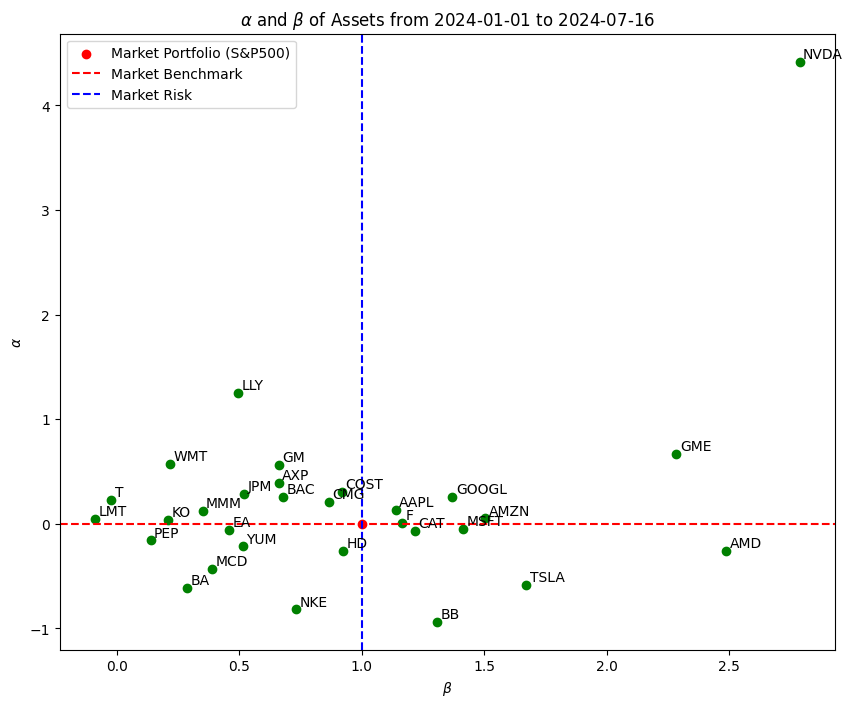

In [10]:
# plot beta vs alpha
plt.figure(figsize=(10, 8))
plt.scatter(1, 0, color='red', label='Market Portfolio (S&P500)') # Market Portfolio

for ticker, value in data.items():
    plt.scatter(value['beta_i'], value['alpha_i'], color='g')
    plt.annotate(
        ticker, 
        xy=(value['beta_i'], value['alpha_i']),
        xycoords='data',
        xytext=(2.5, 2.5),
        textcoords='offset points',
    )
    
# plot reference lines
plt.axhline(0, linestyle='--', label=f'Market Benchmark', color='red')
plt.axvline(1, linestyle='--', label=f'Market Risk', color='blue')

plt.ylabel(rf'$\alpha$')
plt.xlabel(rf'$\beta$')
plt.title(rf'$\alpha$ and $\beta$ of Assets from {alpha_start} to {alpha_end}')

plt.legend()
plt.show()

### Clustering of Sectors

In [11]:
# looking at sector clustering
start_date = '2021-01-01'
end_date = '2023-12-31'

snp500_tickers = [
    'AAPL', 'MSFT', 'NVDA', 'GOOG', 'GOOGL', 'META', 'AVGO', 'ADBE', 'CRM', 'CSCO', 
    'ORCL', 'ACN', 'INTU', 'AMD', 'TXN', 'IBM', 'QCOM', 'NOW', 'ADP', 'V', 'MA', 'PYPL', 
    'FISV', 'CDNS', 'ANSS', 'LRCX', 'ADI', 'KLAC', 'SNPS', 'FTNT', 'MCHP', 'MRVL', 'AMAT', 
    'WDC', 'MU', 'SWKS', 'NXPI', 'QRVO', 'IPGP', 'TEL', 'TDY', 'FFIV', 'PAYC', 'JKHY', 
    'ZM', 'OKTA', 'PANW', 'VRSN', 'WU', 'PAYX', 'GPN', 'FIS', 'DXC', 'AKAM',
    'PG', 'KO', 'PEP', 'COST', 'WMT', 'MO', 'PM', 'MDLZ', 'CL', 'KMB', 'HSY', 'TAP', 'MNST', 
    'K', 'SYY', 'STZ', 'ADM', 'WBA', 'GIS', 'KR', 'CLX', 'CAG', 'CPB', 'KDP', 'CHD', 'HRL', 
    'MKC', 'SJM', 'TSN', 'COTY', 'LW', 'KHC', 'PFGC', 'USFD', 'ACI', 'BJ', 'TGT',
    'JPM', 'BAC', 'WFC', 'C', 'MS', 'GS', 'BLK', 'TFC', 'PNC', 'USB', 'AXP', 'SCHW', 
    'SPGI', 'CME', 'ICE', 'AON', 'MET', 'MMC', 'CB', 'ALL', 'AFL', 'PRU', 'AIG', 'TRV', 'PGR', 
    'HIG', 'LNC', 'CNA', 'NDAQ', 'CBOE', 'FITB', 'RF', 'HBAN', 'KEY', 'CFG', 'MTB', 'ZION', 
    'EWBC', 'CATY', 'WAL', 'FHN', 'NYCB', 'TCBI', 'BOKF', 'HWC', 'IBOC', 'CBSH', 
    'UBSI', 'ONB', 'PRK', 'LBAI', 'FIBK', 'STBA', 'FMNB', 'PB'
]

snp500 = yf.Ticker('^GSPC')
snp500_history = snp500.history(start=start_date, end=end_date, interval='1d')['Close']

stocks = yf.Tickers(snp500_tickers)
stocks_history = stocks.history(start=start_date, end=end_date, interval='1d')['Close']

[*********************100%%**********************]  146 of 146 completed


In [12]:
# generate SML
mu_f = 0.042
mu_m = calculate_expected_return(snp500_history)

beta = np.linspace(0, 2.5, 1000)
sml = mu_f + beta * (mu_m - mu_f)

In [13]:
# calculate beta and returns then group stocks by sector
mu_i = calculate_expected_return(stocks_history)
daily_returns_market = snp500_history.pct_change().dropna()
annual_var_market = np.var(daily_returns_market)*252

sectors = ['Technology', 'Consumer Defensive', 'Financial Services']
sector_data = {}
for index, ticker in enumerate(stocks_history.columns):
    try:
        sector = yf.Ticker(ticker).info['sector']
        
        if sector not in sectors:
            continue
        
        sector_data.setdefault(sector, {'beta_i': [], 'mu_i': []})
                
        stock_returns = stocks_history[ticker].pct_change().dropna()
        sector_data[sector]['beta_i'] = np.append(
            sector_data[sector]['beta_i'],
            calculate_beta(
                stock_returns,
                daily_returns_market,
                annual_var_market
            )
        )
        
        sector_data[sector]['mu_i'] = np.append(
            sector_data[sector]['mu_i'], 
            mu_i[index]
        )
        
    except Exception as e:
        print(e)
        continue

'sector'


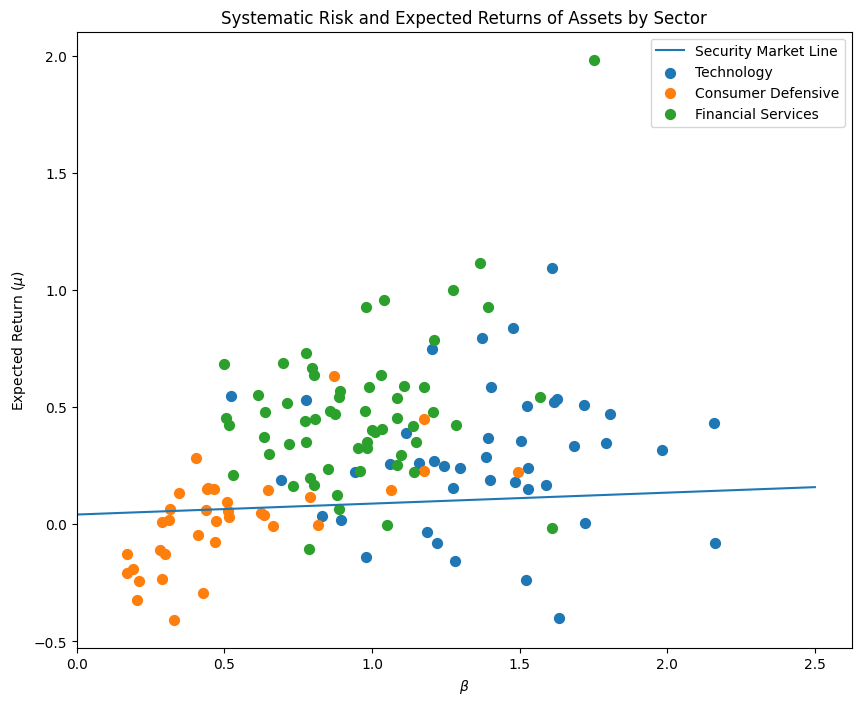

In [14]:
# plot sector clustering
plt.figure(figsize=(10, 8))
plt.plot(beta, sml, label='Security Market Line') # SML

for sector, d in sector_data.items():
    plt.scatter(d['beta_i'], d['mu_i'], s=50, label=sector)

plt.ylabel(rf'Expected Return ($\mu$)')
plt.xlabel(rf'$\beta$')
plt.title('Systematic Risk and Expected Returns of Assets by Sector')
plt.xlim(xmin=0)

plt.legend()
plt.show()